# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle

ModuleNotFoundError: No module named 'pandas'

In [ ]:
from collections import OrderedDict
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.optimizer import RMSProp

In [ ]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=100, output_size=15, weight_init_std=0.01):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
        
        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def predict_label(self, x):
        y = self.predict(x)
        return self.last_layer.softmax_only(y)

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## データを読む1

In [ ]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [ ]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [ ]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, 
                                                                                        test_size=0.3, random_state=1234,
                                                                                        shuffle=True
                                                                                       )

print(X_train.shape, X_test.shape)

(2100, 784) (900, 784)


## 学習

In [ ]:
# epochs = 10
# batch_size = 32
# lr = 0.01

# # 繰り返し回数
# xsize = X_train.shape[0]
# iter_num = np.ceil(xsize / batch_size).astype(np.int)

# # 2層NNのオブジェクト生成
# tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

# train_loss = []
# test_loss = []
# train_accuracy = []
# test_accuracy = []
# for epoch in range(epochs):
#     print("epoch=%s"%epoch)
    
#     # シャッフル
#     idx = np.arange(xsize)
#     np.random.shuffle(idx)

#     for it in range(iter_num):
#         """
#         ランダムなミニバッチを順番に取り出す
#         """
#         mask = idx[batch_size*it : batch_size*(it+1)]
    
#         # ミニバッチの生成
#         x_ = X_train[mask]
#         y_ = y_train[mask]
        
#         # 勾配の計算
#         grads = tnet.gradient(x_, y_)

#         # パラメータの更新
#         for key in tnet.params.keys():
#     #         print(key)
#             tnet.params[key] -= lr * grads[key]

#     ## 学習経過の記録
    
#     # 訓練データにおけるloss
#     train_loss.append(tnet.loss(X_train,  y_train))
    
#     # テストデータにおけるloss
#     test_loss.append(tnet.loss(X_test, y_test))
    
#     # 訓練データにて精度を確認
#     train_accuracy.append(tnet.accuracy(X_train, y_train))

#     # テストデータにて精度を算出
#     test_accuracy.append(tnet.accuracy(X_test, y_test))

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9


In [ ]:
# x = train[:1000,:]
# t = train_labels[:1000,:]

x = X_train
t = y_train
test = X_test
test_labels = y_test

x = x.reshape(-1,1,28,28) # 配列形式の変形
test = test.reshape(-1,1,28,28) # 配列形式の変形

epochs = 10
batch_size = 100

optimizer = RMSProp(lr=0.01, rho=0.9)

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

test_pred = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    train_loss.append(snet.loss(x,  t))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(x, t))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))
    
    # テストデータの推論結果
    test_pred.append(snet.predict_label(test))

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch=0
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20


AttributeError: 'SoftmaxWithLoss' object has no attribute 'softmax_only'

In [ ]:
# # lossのグラフ化
# df_log = pd.DataFrame({"train_loss":train_loss,
#              "test_loss":test_loss,
#              "train_accuracy":train_accuracy,
#              "test_accuracy":test_accuracy})
# df_log.plot()
# plt.ylabel("loss or accuracy")
# plt.xlabel("epochs")
# plt.show()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [ ]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

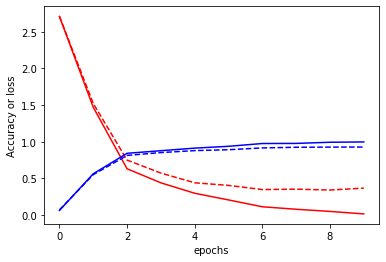

In [ ]:
# x = np.arange(0.0, 5.0, 0.02)
# plt.plot(x, x**2, 'b-')
# plt.show()

# # lossとaccuracyのグラフ化
# df_log = pd.DataFrame({"train_loss":train_loss,
#              "test_loss":test_loss,
#              "train_accuracy":train_accuracy,
#              "test_accuracy":test_accuracy})

# df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
# plt.ylim([0,3])
# plt.ylabel("Accuracy or loss")
# plt.xlabel("epochs")
# plt.show()

x_epoch = np.arange(0, 10, 1)
plt.plot(x_epoch, train_loss, 'r-')
plt.plot(x_epoch, test_loss, 'r--')
plt.plot(x_epoch, train_accuracy, 'b-')
plt.plot(x_epoch, test_accuracy, 'b--')
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

## 学習済みモデルの出力

In [ ]:
with open("katakana_model_r01.pickle", "wb") as f:
    pickle.dump(snet, f)

データの可視化

In [ ]:
print(test_labels.shape)

(900, 15)


In [ ]:
print(test_labels[0])

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [ ]:
print(type(test_labels[0]))

<class 'numpy.ndarray'>


In [ ]:
vec_trans_id = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
print(vec_trans_id)

test_id = np.dot(test_labels[0], vec_trans_id.T)
print(test_id)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
12


In [ ]:
test_id = np.dot(test_labels, vec_trans_id.T)
print(test_id.shape)

# test_id_pred = np.dot(test_pred, vec_trans_id.T)
# print(test_id_pred.shape)

(900,)
(10, 900)


In [ ]:
print(test_pred[0])

[[ 0.21030182  0.00976741 -0.24537196 ... -0.19701337  0.05854181
  -0.07024882]
 [-0.0383881   0.08224991  0.10820312 ... -0.42014066  0.20171698
   0.09985794]
 [-0.03700883  0.05090519  0.14556009 ... -0.44379692  0.15634093
   0.21869483]
 ...
 [ 0.29984725  0.21182041 -0.44472297 ... -0.33201689  0.08435017
  -0.01936266]
 [ 0.3241856   0.02532211 -0.38286098 ... -0.29069436  0.14436195
  -0.09755375]
 [ 0.05570744 -0.02728175  0.00584982 ... -0.27902456  0.09710448
   0.05809629]]


In [ ]:
df = pd.DataFrame({'ground_truth':test_labels, 'prediction':test_pred})
display(df.head(5))  # 先頭から5行を表示
display(df.tail(5))  # 末尾から5行を表示

Exception: Data must be 1-dimensional